In [1]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-03-09 01:34:24--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  --.-KB/s    in 0.05s   

2024-03-09 01:34:24 (62.4 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [2]:
from transformers import pipeline
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
classifier = pipeline("sentiment-analysis")
type(classifier)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

transformers.pipelines.text_classification.TextClassificationPipeline

In [4]:
classifier("That's such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998745918273926}]

In [5]:
classifier("This show is not interesting")

[{'label': 'NEGATIVE', 'score': 0.999795138835907}]

In [6]:
classifier("This show is not bad at all")

[{'label': 'POSITIVE', 'score': 0.9994128942489624}]

In [7]:
classifier("I can't say that this was a good movie")

[{'label': 'NEGATIVE', 'score': 0.9278464913368225}]

In [8]:
classifier("I can't say that this was a bad movie")

[{'label': 'NEGATIVE', 'score': 0.9983667731285095}]

In [9]:
classifier([
    "This course is just what I needed.",
    "I can't understand any of this. Instructor kept telling me to meet the prerequisites. What are prerequisites? Why does he keep saying that?"
])

[{'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9966675639152527}]

In [10]:
import torch

In [11]:
torch.cuda.is_available()

True

In [12]:
torch.cuda.current_device()

0

In [13]:
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [14]:
df = pd.read_csv("AirlineTweets.csv")

In [15]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [16]:
df2 = df[["airline_sentiment", "text"]].copy()

<Axes: >

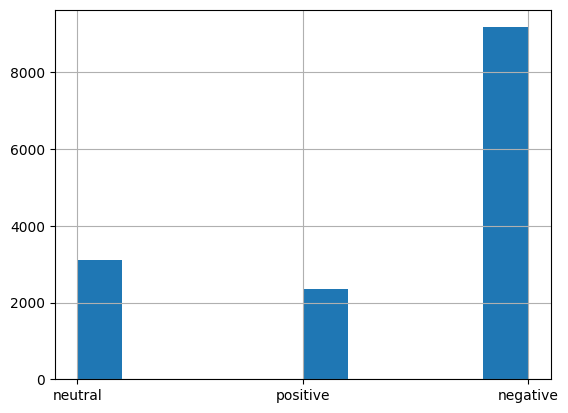

In [17]:
df2["airline_sentiment"].hist()

In [18]:
df2 = df2[df2.airline_sentiment != "neutral"].copy()


In [19]:
target_map = {"positive":1, "negative":0}
df2["target"] = df2["airline_sentiment"].map(target_map)

In [20]:
df2.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [21]:
len(df2)

11541

In [22]:
texts = df2["text"].tolist()
preds = classifier(texts)

In [23]:
preds

[{'label': 'POSITIVE', 'score': 0.6070840954780579},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553212523460388},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957},
 {'label': 'POSITIVE', 'score': 0.9996304512023926},
 {'label': 'NEGATIVE', 'score': 0.9980512857437134},
 {'label': 'POSITIVE', 'score': 0.9964436888694763},
 {'label': 'NEGATIVE', 'score': 0.9968666434288025},
 {'label': 'POSITIVE', 'score': 0.9787647724151611},
 {'label': 'POSITIVE', 'score': 0.9995218515396118},
 {'label': 'NEGATIVE', 'score': 0.9954516291618347},
 {'label': 'POSITIVE', 'score': 0.9995624423027039},
 {'label': 'POSITIVE', 'score': 0.999874830245

In [24]:
probs = [d["score"] if d["label"].startswith("P") else 1 - d["score"] for d in preds]

In [25]:
probs

[0.6070840954780579,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553212523460388,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787647724151611,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.00040477514266967773,
 0.0006322264671325684,
 0.015428304672241211,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934480786323547,
 0.9976067543029785,
 0.8661719560623169,
 0.0003237724304199219,
 0.8415618538856506,
 0.0032317638397216797,
 0.9997846484184265,
 0.1761431097984314,
 0.9993895292282104,
 0.09156662225723267,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.991169810295105,
 0.0125504732131958,
 0.00809931755065918,
 0.99

In [34]:
predicts = [1 if d["label"].startswith("P") else 0 for d in preds]

In [35]:
predicts = np.array(predicts)

In [36]:
print(f"acc: {np.mean(df2['target'] == predicts)}")

acc: 0.8898708950697514


In [37]:
cm = confusion_matrix(df2["target"], predicts, normalize="true")
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

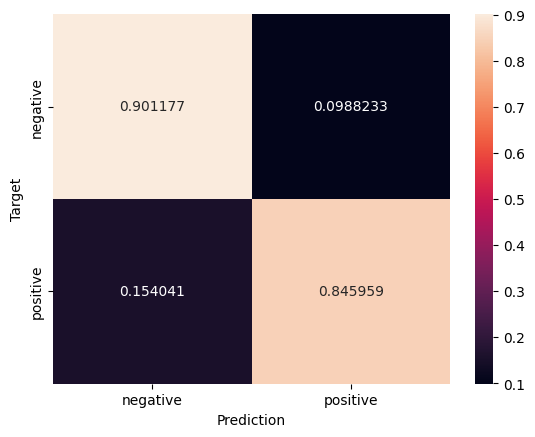

In [38]:
def plot_cm(cm):
  classes = ["negative", "positive"]
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt="g")
  ax.set_xlabel("Prediction")
  ax.set_ylabel("Target")

plot_cm(cm)

In [39]:
f1_score(df2["target"], predicts)

0.7587777566900741

In [40]:
f1_score(1 - df2["target"], 1 - predicts)

0.928647616908999

In [41]:
roc_auc_score(df2["target"], probs)

0.9485934690648773

In [42]:
roc_auc_score(1 - df2["target"], 1 - np.array(probs))

0.9485934690648772